In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [2]:
train_path='D:\DUmDum\deepfakes\dataset\Train'
valid_path='D:\DUmDum\deepfakes\dataset\Validation'
test_path='D:\DUmDum\deepfakes\dataset\Test'

In [3]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=train_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=valid_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
                .flow_from_directory(directory=test_path, target_size=(256,256),classes=['Fake','Real'],batch_size=10)

Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


In [4]:
assert train_batches.n == 140002
assert valid_batches.n == 39428
assert test_batches.n == 10905
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [5]:
train_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

In [6]:
imgs, labels =next(train_batches)

In [7]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1,10,figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

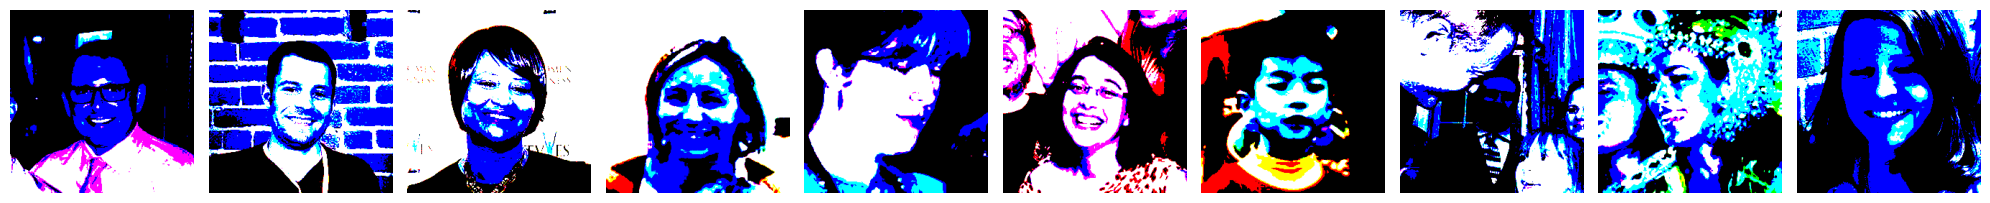

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [8]:
plotImages(imgs)
print(labels)

In [9]:
model = Sequential([
        Conv2D(filters=16, kernel_size=(3,3),activation='relu',padding='same',input_shape=(256,256,3)),
        MaxPool2D(pool_size=(2,2),strides = 2),
        Dropout(0.2),
        Conv2D(filters=32, kernel_size=(3,3), strides = 1 ,activation = 'relu' , padding = 'same'),
        MaxPool2D(pool_size=(2,2),strides=2 ),
        Dropout(0.2),
        Conv2D(filters=64, kernel_size=(3,3), strides = 1 ,activation = 'relu' , padding = 'same'),
        MaxPool2D(pool_size=(2,2),strides=2 ),
        Dropout(0.2),
        Conv2D(filters=128, kernel_size=(3,3), strides = 1 ,activation = 'relu' , padding = 'same'),
        MaxPool2D(pool_size=(2,2),strides=2 ),
        Flatten(),
        Dense(units=2, activation='softmax'), 
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        1

In [11]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [12]:
from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1255945967975605714,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2258055988
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14185626258391541283
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [19]:
model.compile(loss="binary_crossentropy",optimizer=Adam(learning_rate = 0.0001), metrics=['binary_accuracy'])

In [20]:
history = model.fit(x=train_batches,validation_data=valid_batches,epochs=15,verbose=1)

Epoch 1/15
14001/14001 [==============================] - 1815s 129ms/step - loss: 0.4370 - binary_accuracy: 0.8254 - val_loss: 0.2586 - val_binary_accuracy: 0.8894
Epoch 2/15
14001/14001 [==============================] - 1731s 124ms/step - loss: 0.1698 - binary_accuracy: 0.9316 - val_loss: 0.1796 - val_binary_accuracy: 0.9274
Epoch 3/15
14001/14001 [==============================] - 1573s 112ms/step - loss: 0.1326 - binary_accuracy: 0.9475 - val_loss: 0.1664 - val_binary_accuracy: 0.9307
Epoch 4/15
14001/14001 [==============================] - 1566s 112ms/step - loss: 0.1113 - binary_accuracy: 0.9561 - val_loss: 0.1548 - val_binary_accuracy: 0.9370
Epoch 5/15
14001/14001 [==============================] - 1478s 106ms/step - loss: 0.0981 - binary_accuracy: 0.9612 - val_loss: 0.1470 - val_binary_accuracy: 0.9415
Epoch 6/15
14001/14001 [==============================] - 1539s 110ms/step - loss: 0.0877 - binary_accuracy: 0.9655 - val_loss: 0.1504 - val_binary_accuracy: 0.9411
Epoch 7/15

In [21]:
test_batches.classes

array([0, 0, 0, ..., 1, 1, 1])

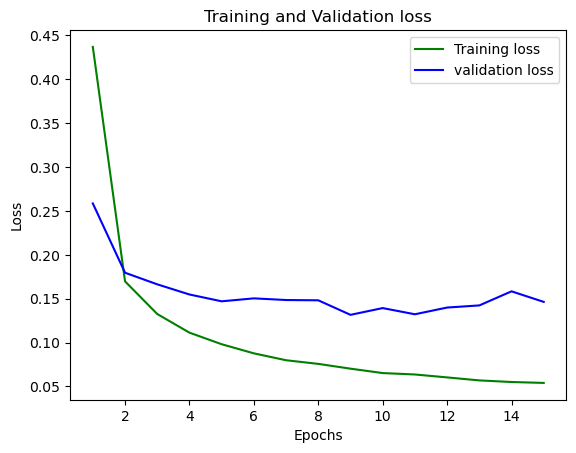

In [32]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

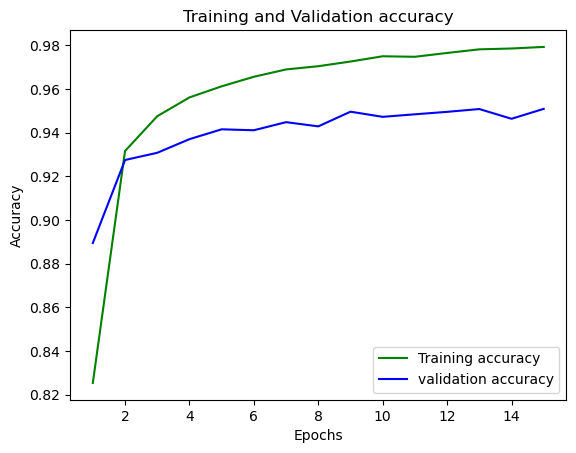

In [33]:
loss = history.history['binary_accuracy']
val_loss = history.history['val_binary_accuracy']
epochs = range(1,16)
plt.plot(epochs, loss, 'g', label='Training accuracy')
plt.plot(epochs, val_loss, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
model.metrics_names

['loss', 'binary_accuracy']

In [27]:
predictions = model.predict(x=test_batches,verbose=1)

1091/1091 [==============================] - 113s 103ms/step


In [28]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions,axis=-1))

In [29]:
def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation =45)
    plt.yticks(tick_marks,classes)
    
    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        print("Normalized confusion Matrix")
    else:
        print("Confusion Matrix,without normalization")
        
    print(cm)
    
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j]),
        horizontalalignment="center",
        color="white" if cm[i,j]>thresh else "black"
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    

In [30]:
test_batches.class_indices

{'Fake': 0, 'Real': 1}

Confusion Matrix,without normalization
[[3089 2403]
 [2982 2431]]


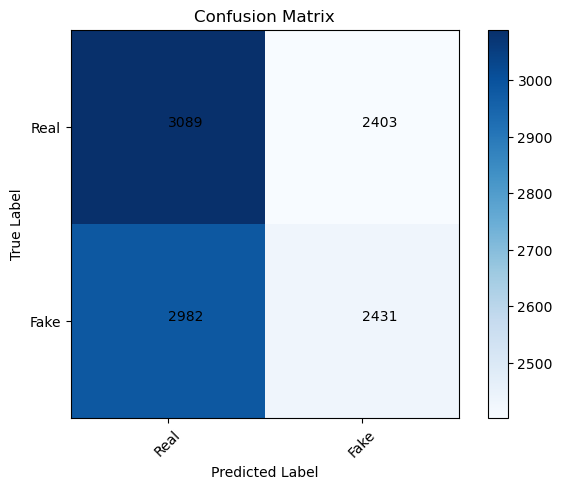

In [31]:
cm_plot_labels=['Real','Fake']
plot_confusion_matrix(cm=cm,classes=cm_plot_labels,title='Confusion Matrix')